In [5]:
from tqdm import tqdm
import time

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec, KeyedVectors
import gensim

import tensorflow as tf
import keras

from tensorflow.keras.layers import Embedding, Dense, GRU, Flatten, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant

from tensorflow.python.client import device_lib

tf.test.is_built_with_cuda()

True

In [6]:
total_data = pd.read_csv('./save_data/naver_review_puretext.csv')
total_data = total_data[['score','review']]
total_data[:10]

,score,review
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...


In [7]:
#긍정과 부정 라벨 붙여주기
#긍정 : score > 3 부정 : score < 3
total_data['label'] = np.select([total_data.score>3],[1],default=0)
total_data[:10]

,score,review,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...,0
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...,0
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요,0
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~,0
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...,0


In [8]:
print('null 유무 : ',total_data.isnull().values.any())
total_data.drop_duplicates(subset=['review'], inplace = True)

print('총 샘플 수 : ',len(total_data))

null 유무 :  False
총 샘플 수 :  199908


훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977
   label  count
0      0  74918
1      1  75013


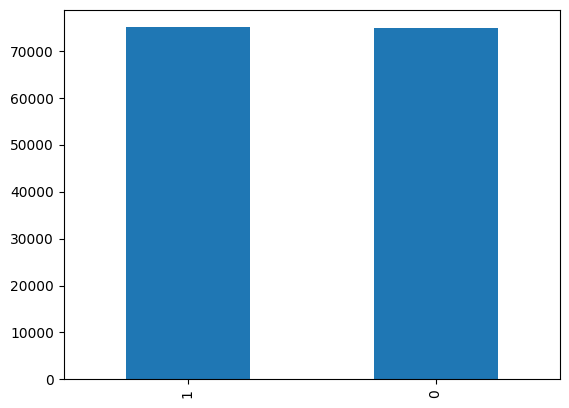

In [9]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)

print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [10]:
mecab = Mecab('C:/mecab/mecab-ko-dic')
stopwords = pd.read_csv('./save_data/stop_word.csv')
tmp = stopwords.values.tolist()
stopwords = []
for s in tqdm(tmp):
    stopwords.append(*s)

train_data['tokenized'] = train_data['review'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['review'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


100%|█████████████████████████████████████████████████████████████████████████| 1270/1270 [00:00<00:00, 1320794.96it/s]


In [11]:
print(train_data.head())

        score                                             review  label  \
59662       2  사이즈를 3센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많...      0   
12432       2                     ㅂ불만족.. 빗이 아픔 .. 멍이피부에 빗질못해주겟네요      0   
146475      1  이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요. 혹시나해서 다시 빼보니 물이 다시 ...      0   
158057      5                                         적당하고 만족합니다      1   
70211       2                   편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요      0   

                                                tokenized  
59662   [사이즈, 3, 센치, 씩, 늘린, 건데, 도, 작, 아요, 색상, 은, 완전, 달...  
12432   [ㅂ, 불만족, ., ., 빗이, 아픔, ., ., 멍, 피부, 빗, 질, 못해, ...  
146475  [제품, 쓰, 고, 만, 변기, 물, 잘, 안, 내려갔, 어요, ., 혹시나, 해서...  
158057                                   [적당, 고, 만족, 합니다]  
70211   [편하, 자고, 이용, 는, 밀키, 튼, 데, 손, 은, 근, 많이, 서, 는, 패...  


In [12]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 42112
등장 빈도가 1번 이하인 희귀 단어의 수: 19687
단어 집합에서 희귀 단어의 비율: 46.74914513677811
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7661193662772054


In [14]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 22427


In [15]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [16]:
print(X_train[0:])
print(len(X_train[0:]))


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



리뷰의 최대 길이 : 88
리뷰의 평균 길이 : 17.13924405226404


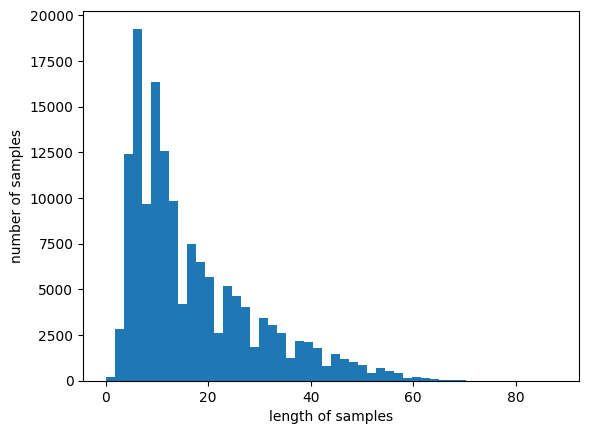

In [17]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
max_len = 45

below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 45 이하인 샘플의 비율: 96.09020149268663


In [20]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [38]:
model_only_reviewdata = gensim.models.Word2Vec.load('./model/only_review.model')
print('리뷰만 읽은 데이터')
print(model_only_reviewdata.wv.vectors.shape)
#모델별 단어 수, 벡터의 차원수들
#OR = only review data
OR_vocab_size = len(X_train)
OR_vector_dim = 200
OR_embedding_matrix = np.zeros((OR_vocab_size,200))
print(np.shape(OR_embedding_matrix))

def get_vector(word, word2vec_model):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None
    
for word, index in tokenizer.word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = get_vector(word, model_only_reviewdata.wv)
    if vector_value is not None :
        OR_embedding_matrix[index] = vector_value

리뷰만 읽은 데이터
(23916, 200)
(149931, 200)


In [39]:
embedding_dim = 200
hidden_units = 128

model = Sequential()
model.add(Embedding(OR_vocab_size,OR_vector_dim, embeddings_initializer=Constant(OR_embedding_matrix)))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='relu'))

es = EarlyStopping(monitor='val_loss',patience=4)
mc = ModelCheckpoint('./model/GRU_Model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.4947 - acc: 0.8435
Epoch 1: val_acc improved from -inf to 0.89569, saving model to ./model\GRU_Model.h5
1875/1875 [==============================] - 82s 43ms/step - loss: 0.4947 - acc: 0.8435 - val_loss: 0.4208 - val_acc: 0.8957
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.3981 - acc: 0.8926
Epoch 2: val_acc did not improve from 0.89569
1875/1875 [==============================] - 66s 35ms/step - loss: 0.3981 - acc: 0.8926 - val_loss: 0.3808 - val_acc: 0.8822
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.3505 - acc: 0.8971
Epoch 3: val_acc did not improve from 0.89569
1875/1875 [==============================] - 66s 35ms/step - loss: 0.3505 - acc: 0.8971 - val_loss: 0.3644 - val_acc: 0.8945
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.3353 - acc: 0.8994
Epoch 4: val_acc improved from 0.89569 to 0.89912, saving model to ./model\G

In [40]:
# Evaluate the model on the test data using `evaluate`
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:3])
print("predictions shape:", predictions.shape)

1562/1562 [==============================] - 6s 4ms/step - loss: 0.4473 - acc: 0.8912

 테스트 정확도: 0.8912
Generate predictions for 3 samples
1/1 [==============================] - 0s 290ms/step
predictions shape: (3, 1)


In [41]:
#load_model = tf.keras.models.load_model('./model/GRU_Model.h5')
mecab = Mecab("C:/mecab/mecab-ko-dic")
stopwords = pd.read_csv('./save_data/stop_word.csv')
tmp = stopwords.values.tolist()
max_len = 80
stopwords = []
for s in tmp:
    stopwords.append(*s)
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = mecab.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len)
    score = float(model.predict(pad_new))
    print("score : ", score)
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))


In [42]:
time_sum = 0
t1 = time.time()
print(sentiment_predict('이거 진짜 좋아요 ㅠㅠ'))
t2 = time.time()

time_sum += (t2 - t1)
print(time_sum)

1/1 [==============================] - 0s 297ms/step
score :  0.8417333960533142
84.17% 확률로 긍정 리뷰입니다.
None
0.33500027656555176


In [7]:
#model.save('./model/GRU_Model.h5')
#load_model = tf.keras.models.load_model('./model/GRU_Model.h5')

import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)
    
# loading
#with open('tokenizer.pickle', 'rb') as handle:
#    tokenizer = pickle.load(handle)